In [1]:
import pandas as pd
import numpy as np
import warnings
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt 


### Settings

In [2]:
# cancerType, cancerTypeDetailed, or oncotreeLevel2
analysis_type = 'cancerType'

In [3]:
config = "../global_config_bash_4.rc"

In [4]:
with open(config, 'r') as f :
    bash_script_content = f.read()
    lines = bash_script_content.splitlines()
paths = {}
for line in lines:
    line = line.strip()
    if line and '=' in line:
        key, value = line.split('=', 1)
        key = key.strip()
        value = value.strip()
        # Handle variable references
        while '${' in value:
            start_index = value.find('${')
            end_index = value.find('}', start_index)
            if start_index != -1 and end_index != -1:
                variable_name = value[start_index + 2:end_index]
                if variable_name in paths:
                    value = value[:start_index] + paths[variable_name] + value[end_index + 1:]
                else:
                    break  # Stop if variable reference not found
        paths[key] = value.strip('"\'')  # Remove surrounding quotes if any

### Oncotree Codes

In [5]:
import requests

url = 'https://oncotree.mskcc.org/api/tumorTypes/tree'
headers = {
    'Accept': 'application/json'
}

response = requests.get(url, headers=headers)

def parse_tree(data):
    if not isinstance(data, dict):
        return data
    
    parsed_data = {}
    for key, value in data.items():
        if isinstance(value, dict):
            parsed_data[key] = parse_tree(value)
        elif isinstance(value, list):
            parsed_data[key] = [parse_tree(item) for item in value]
        else:
            parsed_data[key] = value
    
    return parsed_data

parsed_data = parse_tree(response.json())

In [6]:
oncotree_dict = {}

def dfs_oncotree(node):
    codes = [node['code']]
    # Recursively traverse children
    for child in node['children'] :
        codes.extend(dfs_oncotree(node['children'][child]))
    return codes

for tissue in parsed_data['TISSUE']['children'] :
    for specific in parsed_data['TISSUE']['children'][tissue]['children'] :
        oncotree_dict[parsed_data['TISSUE']['children'][tissue]['children'][specific]['name']] = set(dfs_oncotree(parsed_data['TISSUE']['children'][tissue]['children'][specific]))


### Whole Cohort

In [7]:
	
# follow up timeline data (from CDSI github)
timeline_data = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_timeline_follow_up.txt', sep = '\t')
diagnosis = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_diagnosis.txt', sep = '\t')

# Merged ECHO results
echo = pd.read_csv(paths['mergedOutputDirectory'] + '/merged.ECHO_results.csv')
# FileA in the manifest directory
manifest = pd.read_csv(paths['manifestDirectory'] + '/FileA.tsv', sep = '\t')

Set up dataframes

In [8]:
echo['patientId'] = echo['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
echo['tumorSampleId'] = echo['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
echo['normalSampleId'] = echo.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
echo.drop('sample_id', axis = 1, inplace = True)
echo = echo[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

manifest = manifest[['sampleId', 'cancerType', 'cancerTypeDetailed', 'osStatus', 'osMonths', 'oncotreeCode']]
echo = pd.merge(echo, manifest, left_on = 'tumorSampleId', right_on = 'sampleId', how = 'left')

echo['oncotreeLevel2'] = ""
for i, row in echo.iterrows() :
    for key in oncotree_dict :
        if row['oncotreeCode'] in oncotree_dict[key] :
            echo.loc[i, 'oncotreeLevel2'] = key

Get timeline data

In [9]:
diagnosis_dict = {}
last_contact_dict = {}

for i, row in timeline_data.iterrows() :
    if row['SOURCE'] == "Last Contact" :
        last_contact_dict[row['PATIENT_ID']] = row['START_DATE']

for i, row in diagnosis.iterrows() :
    if row['PATIENT_ID'] in diagnosis_dict :
        diagnosis_dict[row['PATIENT_ID']] = min(diagnosis_dict[row['PATIENT_ID']], row['START_DATE'])
    else :
        diagnosis_dict[row['PATIENT_ID']] = row['START_DATE']


ecDNA and amplification status data

In [10]:
ecDNAStatus_dict = {}
ampStatus_dict = {}
ctype_dict = {}
living_dict = {}
death_dict = {}

for i, row in echo.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        ampStatus_dict[row['patientId']] = True
        ecDNAStatus_dict[row['patientId']] = True
    elif row['ecDNA_status'] == 'non-ecDNA' :
        ampStatus_dict[row['patientId']] = True
    ctype_dict[row['patientId']] = row[analysis_type]
    if row['osStatus'] == 'LIVING' :
        living_dict[row['patientId']] = True
    if row['osStatus'] == 'DECEASED' :
        death_dict[row['patientId']] = True

Create new dataframe with the data we need

In [11]:
for_km = pd.DataFrame(echo['patientId'].unique(), columns = ['patientId'])
for_km['ecDNAStatus'] = False
for_km['echoAmpStatus'] = False
for_km['time'] = np.nan
for_km['osStatusInt'] = np.nan
for_km[analysis_type] = "na"
for_km['combinedStatus'] = "na"

for i, row in for_km.iterrows() :
    p_id = row['patientId']
    if p_id in ecDNAStatus_dict :
        for_km.loc[i, 'ecDNAStatus'] = True
    if p_id in ampStatus_dict :
        for_km.loc[i, 'echoAmpStatus'] = True
    if p_id in last_contact_dict and p_id in diagnosis_dict :
        for_km.loc[i, 'time'] = last_contact_dict[p_id] - diagnosis_dict[p_id]
    if p_id in death_dict :
        for_km.loc[i, 'osStatusInt'] = 1
    elif p_id in living_dict :
        for_km.loc[i, 'osStatusInt'] = 0
    if p_id in ctype_dict :
        for_km.loc[i, analysis_type] = ctype_dict[p_id]

for i, row in for_km.iterrows() :
    if row['ecDNAStatus'] and row["echoAmpStatus"] :
        for_km.loc[i, 'combinedStatus'] = "ecDNA & Amp"
    elif not row['ecDNAStatus'] and row['echoAmpStatus'] :
        for_km.loc[i, 'combinedStatus'] = "No ecDNA & Amp"
    elif not row['ecDNAStatus'] and not row['echoAmpStatus'] :
        for_km.loc[i, 'combinedStatus'] = "No ecDNA & No Amp"

for_km_nona = for_km.dropna(subset = ['time', 'osStatusInt'])
for_km_nona = for_km_nona[for_km_nona[analysis_type] != 'na']

KM Curves

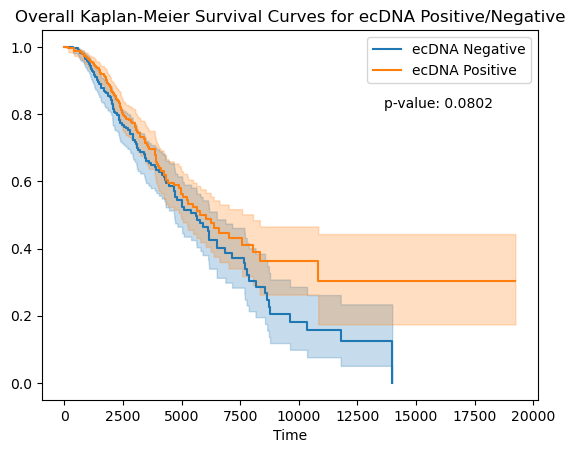

In [12]:
import warnings
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Ignore all warnings
warnings.filterwarnings('ignore')

kmf = KaplanMeierFitter()
for status in for_km_nona['ecDNAStatus'].unique():
    subset = for_km_nona[for_km_nona['ecDNAStatus'] == status]
    kmf.fit(subset['time'], event_observed=(subset['osStatusInt'] == 1))
    # labels
    if status == True :
        status = "ecDNA Positive"
    else :
        status = "ecDNA Negative"
    kmf.plot(show_censors=False, ci_show=True, label=f'{status}')

# get p-value
results = logrank_test(for_km_nona[for_km_nona['ecDNAStatus'] == True]['time'], 
                           for_km_nona[for_km_nona['ecDNAStatus'] == False]['time'],
                           event_observed_A=for_km_nona[for_km_nona['ecDNAStatus'] == True]['osStatusInt'], 
                           event_observed_B=for_km_nona[for_km_nona['ecDNAStatus'] == False]['osStatusInt'])
plt.text(0.8, 0.8, f'p-value: {results.p_value:.4f}', horizontalalignment='center', 
             verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

# # Add labels and legend
plt.title('Overall Kaplan-Meier Survival Curves for ecDNA Positive/Negative')
plt.xlabel("Time")
plt.legend()

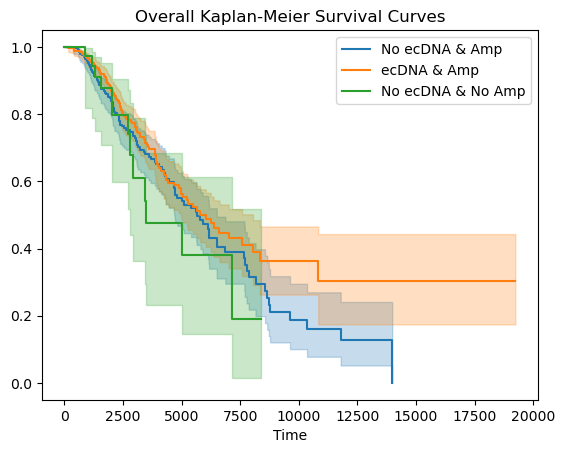

In [13]:
import warnings
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Ignore all warnings
warnings.filterwarnings('ignore')

kmf = KaplanMeierFitter()
for status in for_km_nona['combinedStatus'].unique():
    subset = for_km_nona[for_km_nona['combinedStatus'] == status]
    kmf.fit(subset['time'], event_observed=(subset['osStatusInt'] == 1))
    kmf.plot(show_censors=False, ci_show=True, label=f'{status}')

# # Add labels and legend
plt.title('Overall Kaplan-Meier Survival Curves')
plt.xlabel("Time")
plt.legend()

In [14]:
from itertools import combinations
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

statuses = for_km_nona['combinedStatus'].unique()
pairwise_tests = {}

for group1, group2 in combinations(statuses, 2) :
    group1_data = for_km_nona[for_km_nona['combinedStatus'] == group1]
    group2_data = for_km_nona[for_km_nona['combinedStatus'] == group2]

    # Fit KM curves
    kmf.fit(group1_data['time'], event_observed=(group1_data['osStatusInt'] == 1))
    kmf2.fit(group2_data['time'], event_observed=(group2_data['osStatusInt'] == 1))
    
    # Perform log-rank test
    result = logrank_test(group1_data['time'], group2_data['time'], event_observed_A=(group1_data['osStatusInt'] == 1), event_observed_B=(group2_data['osStatusInt'] == 1))
    
    # Store p-value in dictionary
    pairwise_tests[(group1, group2)] = result.p_value

p_values_matrix = pd.DataFrame(index=statuses, columns=statuses)
for (group1, group2), p_value in pairwise_tests.items():
    if group1 != group2:
        p_values_matrix.loc[group1, group2] = p_value
p_values_matrix = p_values_matrix.fillna("")

print("P-values for KM Curves")

styled_matrix = p_values_matrix.iloc[:-1, 1:].style.set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px solid black')]
}, {
    'selector': 'td',
    'props': [('border', '1px solid black')]
}])
styled_matrix

P-values for KM Curves


,ecDNA & Amp,No ecDNA & No Amp
No ecDNA & Amp,0.116772,0.494114
ecDNA & Amp,,0.207656


### Cancer Type Level

In [15]:
cancer_types_count = {}
for key, value in ctype_dict.items() :
    if value not in cancer_types_count :
        cancer_types_count[value] = 1
    else :
        cancer_types_count[value] += 1

cancer_types_to_use = []
for key, value in cancer_types_count.items() :
    if isinstance(key, str) :
        if value >= 10 :
            cancer_types_to_use.append(key)

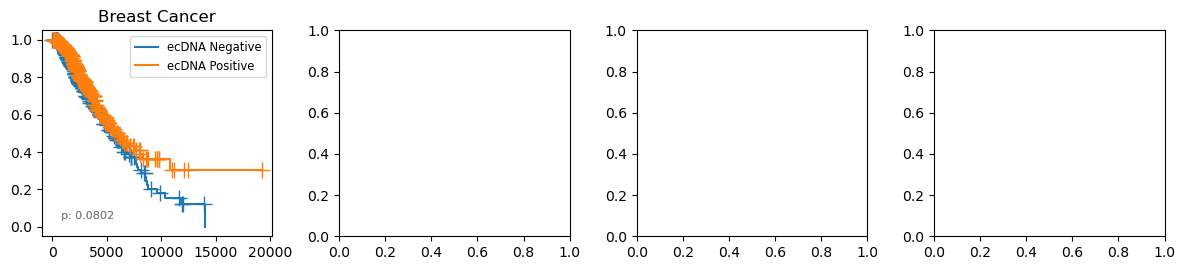

In [35]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

from lifelines import KaplanMeierFitter

# Allow for multiple plots
fig, axs = plt.subplots((len(cancer_types_to_use)+3)//4, 4, figsize = (12, 2 + 0.8 * len(cancer_types_to_use)))
axs = axs.flatten()
for i in range(len(cancer_types_to_use)) :
    # Get specific data set for the cancer type
    ecDNA_patient_specific = for_km_nona[for_km_nona[analysis_type] == cancer_types_to_use[i]]

    for status in sorted(ecDNA_patient_specific['ecDNAStatus'].unique()):

        kmf = KaplanMeierFitter()
        subset = ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == status]
        kmf.fit(subset['time'], event_observed=(subset['osStatusInt'] == 1))
        # labels
        if status == True :
            status = "ecDNA Positive"
        else :
            status = "ecDNA Negative"
        kmf.plot(show_censors=True, ci_show=False, label=f'{status}', ax = axs[i])
        axs[i].legend(loc='upper right', fontsize='small')

        axs[i].set_title(cancer_types_to_use[i])
        axs[i].set_xlabel("")
    
        # Get p value
        try :
            results = logrank_test(ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == True]['time'], 
                                    ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == False]['time'],
                                    event_observed_A=ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == True]['osStatusInt'], 
                                    event_observed_B=ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == False]['osStatusInt'])
            if not results.p_value == np.nan :
                axs[i].text(0.2,0.1, f'p: {results.p_value:.4f}', horizontalalignment='center',
                    verticalalignment='center',
                    transform=axs[i].transAxes,
                    fontsize=8, 
                    color='grey')
        except :
            _ = 5
plt.tight_layout()
plt.show()

Using ECHO Amplifications


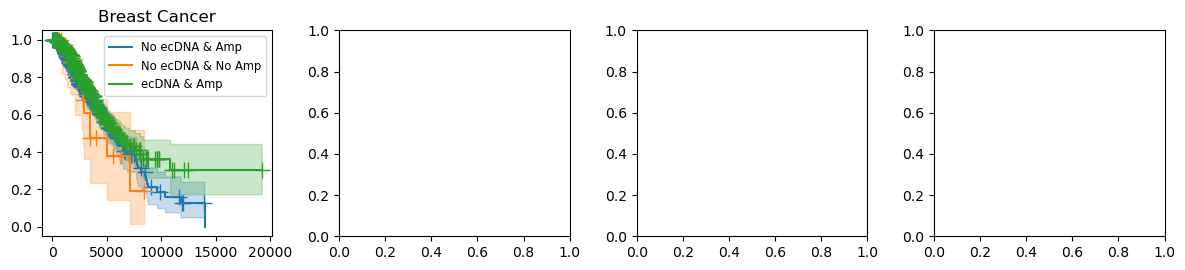

In [17]:
import warnings

print("Using ECHO Amplifications")
# Ignore all warnings
warnings.filterwarnings('ignore')

# Allow for multiple plots
fig, axs = plt.subplots((len(cancer_types_to_use)+3)//4, 4, figsize = (12, 2 + 0.8 * len(cancer_types_to_use)))
axs = axs.flatten()
for i in range(len(cancer_types_to_use)) :
    # Get specific data set for the cancer type
    ecDNA_patient_specific = for_km_nona[for_km_nona[analysis_type] == cancer_types_to_use[i]]

    for status in sorted(ecDNA_patient_specific['combinedStatus'].unique()):

        kmf = KaplanMeierFitter()
        subset = ecDNA_patient_specific[ecDNA_patient_specific['combinedStatus'] == status]
        kmf.fit(subset['time'], event_observed=(subset['osStatusInt'] == 1))

        kmf.plot(show_censors=True, ci_show=True, label=f'{status}', ax = axs[i])
        axs[i].legend(loc='upper right', fontsize='small')

        axs[i].set_title(cancer_types_to_use[i])
        axs[i].set_xlabel("")
plt.tight_layout()
plt.show()

In [18]:
cancer_types_to_use

['Breast Cancer']

Cox models

In [19]:
import warnings
warnings.filterwarnings("ignore")
from lifelines import CoxPHFitter

cox_df = pd.DataFrame(columns = ['ctype', 'p_value', 'hazardRatio', 'upper', 'lower'])

# Create a dataframe for cox model output for each cancer type
for ctype in cancer_types_to_use :
    try :
        ecDNA_patient_cox_specific = for_km_nona[for_km_nona[analysis_type] == ctype]

        cox = CoxPHFitter()
        covariates = ['time', 'osStatusInt', 'ecDNAStatus']
        cox.fit(ecDNA_patient_cox_specific[covariates], duration_col = 'time', event_col = 'osStatusInt')
        new_row = {
            'ctype' : ctype,
            'p_value' : cox.summary['p'][0],
            'hazardRatio' : cox.summary['exp(coef)'][0],
            'upper' : cox.summary['exp(coef) upper 95%'][0],
            'lower' : cox.summary['exp(coef) lower 95%'][0]
        }
        new_df = pd.DataFrame([new_row])
        cox_df = pd.concat([cox_df, new_df], ignore_index = True)

    except :
        print(f"{ctype}: Convergence Not Found")

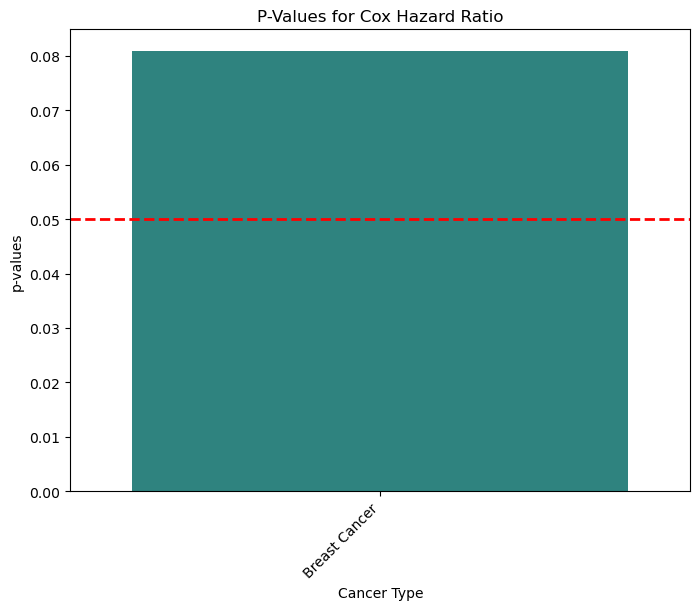

In [20]:
import seaborn as sns

cox_df = cox_df.sort_values(by='p_value')
plt.figure(figsize=(8, 6))
bars = sns.barplot(x='ctype', y='p_value', data=cox_df, palette='viridis')
plt.xlabel('Cancer Type')
plt.ylabel('p-values')
plt.title('Sorted DataFrame Bar Plot')
bars.set_xticklabels(bars.get_xticklabels(), rotation=45, ha='right')
plt.axhline(y=0.05, color='r', linestyle='--', linewidth=2)
plt.title("P-Values for Cox Hazard Ratio")


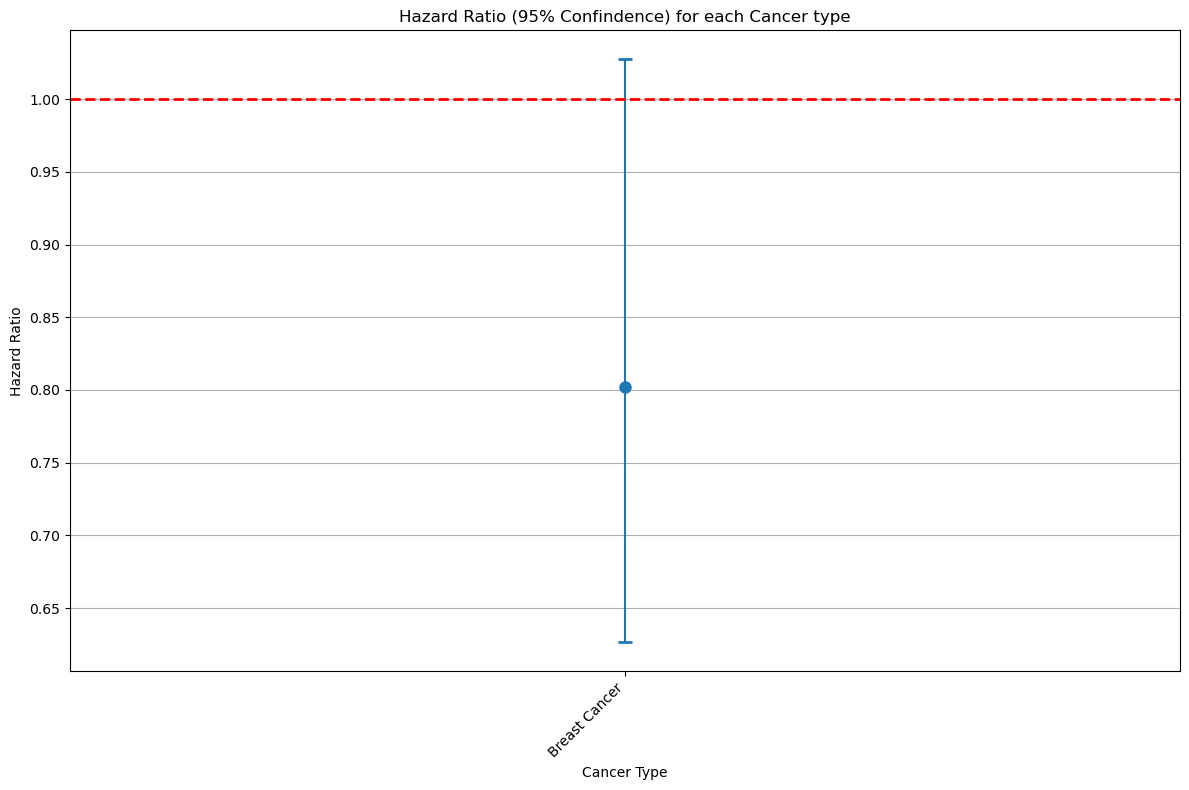

In [21]:
non_zero = cox_df[cox_df['lower'] != 0]

# Number of rows in the DataFrame
num_rows = non_zero.shape[0]

# Plotting points with error bars for each row
plt.figure(figsize=(12, 8))

# Plot points
positions = np.arange(num_rows)
plt.errorbar(positions, non_zero['hazardRatio'], yerr=[non_zero['hazardRatio'] - non_zero['lower'], non_zero['upper'] - non_zero['hazardRatio']],
             fmt='o', markersize=8, capsize=5, capthick=2)

# Set x-axis ticks and labels
plt.xlabel('Cancer Type')
plt.xticks(positions, non_zero['ctype'],rotation=45, ha='right')


# Add labels and title
plt.ylabel('Hazard Ratio')
plt.title('Hazard Ratio (95% Confindence) for each Cancer type')
plt.axhline(y=1, color='r', linestyle='--', linewidth=2)

plt.grid(True, axis='y')  # Add grid lines for better visualization
plt.tight_layout()
plt.show()

In [22]:
import warnings
warnings.filterwarnings("ignore")
from lifelines import CoxPHFitter

cox_df = pd.DataFrame(columns = ['ctype', 'p_value', 'hazardRatio', 'upper', 'lower'])

# Create a dataframe for cox model output for each cancer type
for ctype in cancer_types_to_use :
    try :
        ecDNA_patient_cox_specific = for_km_nona[for_km_nona[analysis_type] == ctype]

        cox = CoxPHFitter()
        covariates = ['time', 'osStatusInt', 'ecDNAStatus', 'echoAmpStatus']
        cox.fit(ecDNA_patient_cox_specific[covariates], duration_col = 'time', event_col = 'osStatusInt')
        new_row = {
            'ctype' : ctype,
            'p_value' : cox.summary['p'][0],
            'hazardRatio' : cox.summary['exp(coef)'][0],
            'upper' : cox.summary['exp(coef) upper 95%'][0],
            'lower' : cox.summary['exp(coef) lower 95%'][0]
        }
        new_df = pd.DataFrame([new_row])
        cox_df = pd.concat([cox_df, new_df], ignore_index = True)

    except :
        print(f"{ctype}: Convergence Not Found")

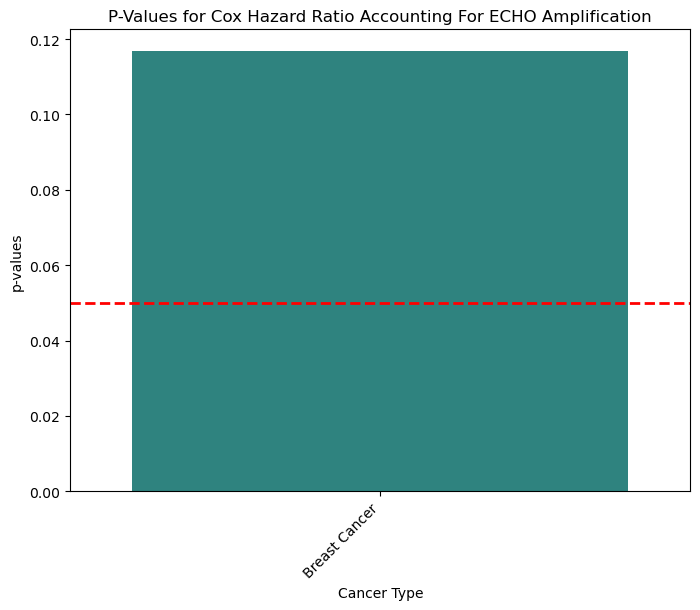

In [23]:
import seaborn as sns

cox_df = cox_df.sort_values(by='p_value')
plt.figure(figsize=(8, 6))
bars = sns.barplot(x='ctype', y='p_value', data=cox_df, palette='viridis')
plt.xlabel('Cancer Type')
plt.ylabel('p-values')
plt.title('Sorted DataFrame Bar Plot')
bars.set_xticklabels(bars.get_xticklabels(), rotation=45, ha='right')
plt.axhline(y=0.05, color='r', linestyle='--', linewidth=2)
plt.title("P-Values for Cox Hazard Ratio Accounting For ECHO Amplification")
plt.show()

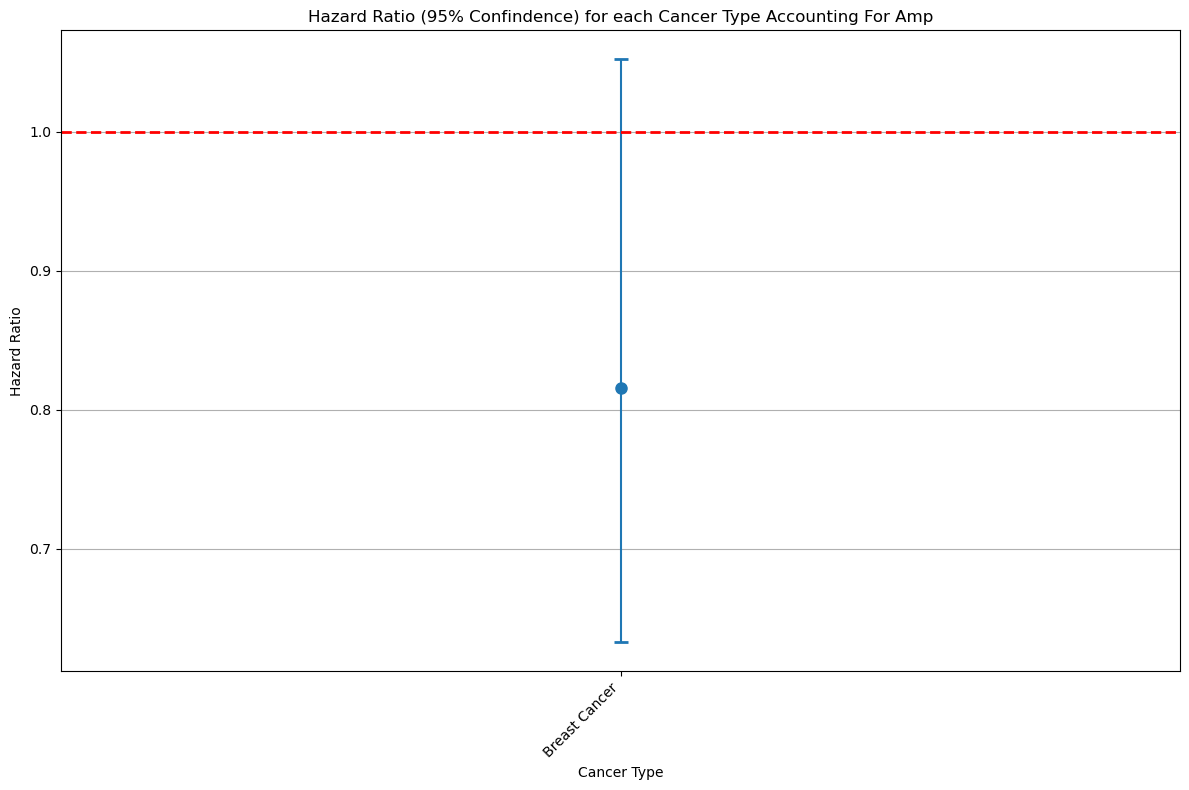

In [24]:
non_zero = cox_df[cox_df['lower'] != 0]

# Number of rows in the DataFrame
num_rows = non_zero.shape[0]

# Plotting points with error bars for each row
plt.figure(figsize=(12, 8))

# Plot points
positions = np.arange(num_rows)
plt.errorbar(positions, non_zero['hazardRatio'], yerr=[non_zero['hazardRatio'] - non_zero['lower'], non_zero['upper'] - non_zero['hazardRatio']],
             fmt='o', markersize=8, capsize=5, capthick=2)

# Set x-axis ticks and labels
plt.xlabel('Cancer Type')
plt.xticks(positions, non_zero['ctype'],rotation=45, ha='right')


# Add labels and title
plt.ylabel('Hazard Ratio')
plt.title('Hazard Ratio (95% Confindence) for each Cancer Type Accounting For Amp')
plt.axhline(y=1, color='r', linestyle='--', linewidth=2)

plt.grid(True, axis='y')  # Add grid lines for better visualization
plt.tight_layout()
plt.show()

### Single Gene Single Cancer (With FACETS)

In [25]:
geneToStudy = 'ERBB2'
cancerTypeToStudy = 'Breast Cancer'

In [26]:
facets = pd.read_csv("../mycn_facets_merged.tsv", sep = '\t', index_col = False)

In [27]:
def extract_patient(text):
    parts = text.split('-')
    if len(parts) >= 3:
        return '-'.join(parts[:2])
    else:
        return text


facets['patientId'] = facets['sample'].apply(extract_patient)

In [28]:
facets_cn = {}
for i, row in facets.iterrows() :
    facets_cn[row['patientId']] = row['tcn']

In [29]:
echo_ctype = echo[echo[analysis_type] == cancerTypeToStudy]

# create a dataframe just for the one gene in the one cancer type
specific_gene_ctype = pd.DataFrame({'patientId': echo_ctype['patientId'].unique()})
specific_gene_ctype['ecDNA_status'] = False
specific_gene_ctype['osStatusInt'] = np.nan
specific_gene_ctype['time'] = np.nan
specific_gene_ctype['amp_echo'] = False
specific_gene_ctype['cn_echo'] = 2
specific_gene_ctype['cn_facets'] = np.nan
specific_gene_ctype['combinedStatus'] = ""


# connect patient IDs to indexes
gene_dict = {}
for i, row in specific_gene_ctype.iterrows() :
    gene_dict[row['patientId']] = i

# Fill in survival info
for i, row in for_km.iterrows() :
    if row[analysis_type] == cancerTypeToStudy :
        specific_gene_ctype.loc[gene_dict[row['patientId']], 'time'] = row['time']
        specific_gene_ctype.loc[gene_dict[row['patientId']], 'osStatusInt'] = row['osStatusInt']
        specific_gene_ctype.loc[gene_dict[row['patientId']], 'combinedStatus'] = row['combinedStatus']


# Fill in echo info
for i, row in echo_ctype.iterrows() :
    if row['gene'] == geneToStudy :
        specific_gene_ctype.loc[gene_dict[row['patientId']], 'cn_echo'] = row['cn']
        specific_gene_ctype.loc[gene_dict[row['patientId']], 'ecDNA_status'] = (row['ecDNA_status'] == 'ecDNA')
        specific_gene_ctype.loc[gene_dict[row['patientId']], 'amp_echo'] = True

# Fill in FACETS copy numbers
for i, row in facets.iterrows() :
    if row['patientId'] in gene_dict :
        specific_gene_ctype.loc[gene_dict[row['patientId']], 'cn_facets'] = row['tcn']


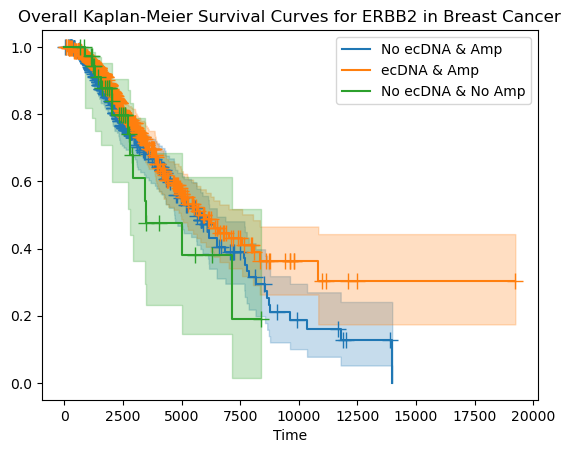

In [30]:
import warnings
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

specific_gene_ctype_cox = specific_gene_ctype.dropna(subset = ['combinedStatus', 'osStatusInt', 'time'])

# Ignore all warnings
warnings.filterwarnings('ignore')

kmf = KaplanMeierFitter()
for status in specific_gene_ctype_cox['combinedStatus'].unique():
    subset = specific_gene_ctype_cox[specific_gene_ctype_cox['combinedStatus'] == status]
    kmf.fit(subset['time'], event_observed=(subset['osStatusInt'] == 1))
    kmf.plot(show_censors=True, ci_show=True, label=f'{status}')

# # Add labels and legend
plt.title(f'Overall Kaplan-Meier Survival Curves for {geneToStudy} in {cancerTypeToStudy}')
plt.xlabel("Time")
plt.legend()

In [31]:
from itertools import combinations
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

statuses = specific_gene_ctype_cox['combinedStatus'].unique()
specific_gene_ctype_cox['osStatusInt'] = specific_gene_ctype_cox['osStatusInt'].astype(int)
pairwise_tests = {}

for group1, group2 in combinations(statuses, 2) :
    group1_data = specific_gene_ctype_cox[specific_gene_ctype_cox['combinedStatus'] == group1]
    group2_data = specific_gene_ctype_cox[specific_gene_ctype_cox['combinedStatus'] == group2]

    # Fit KM curves
    kmf.fit(group1_data['time'], event_observed=(group1_data['osStatusInt'] == 1))
    kmf2.fit(group2_data['time'], event_observed=(group2_data['osStatusInt'] == 1))
    
    # Perform log-rank test
    result = logrank_test(group1_data['time'], group2_data['time'], event_observed_A=(group1_data['osStatusInt'] == 1), event_observed_B=(group2_data['osStatusInt'] == 1))
    
    # Store p-value in dictionary
    pairwise_tests[(group1, group2)] = result.p_value

p_values_matrix = pd.DataFrame(index=statuses, columns=statuses)
for (group1, group2), p_value in pairwise_tests.items():
    if group1 != group2:
        p_values_matrix.loc[group1, group2] = p_value
p_values_matrix = p_values_matrix.fillna("")

print("P-values for KM Curves")

styled_matrix = p_values_matrix.iloc[:-1, 1:].style.set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px solid black')]
}, {
    'selector': 'td',
    'props': [('border', '1px solid black')]
}])
styled_matrix

P-values for KM Curves


,ecDNA & Amp,No ecDNA & No Amp
No ecDNA & Amp,0.116772,0.494114
ecDNA & Amp,,0.207656


Graphing different hazard ratios/p-values

In [32]:
specific_cox_df = pd.DataFrame(columns = ['atype', 'p_value', 'hazardRatio', 'upper', 'lower'])

gene_cox = specific_gene_ctype.dropna(subset = ['time', 'osStatusInt', 'ecDNA_status', 'amp_echo'])
gene_cox['osStatusInt'] = gene_cox['osStatusInt'].astype(int)
from lifelines import CoxPHFitter

# Just ecDNA +/-
cox = CoxPHFitter()
covariates = ['time', 'osStatusInt', 'ecDNA_status']
cox.fit(gene_cox[covariates], duration_col = 'time', event_col = 'osStatusInt')
new_row = {
    'atype' : "ecDNA Status",
    'p_value' : cox.summary['p'][0],
    'hazardRatio' : cox.summary['exp(coef)']['ecDNA_status'],
    'upper' : cox.summary['exp(coef) upper 95%']['ecDNA_status'],
    'lower' : cox.summary['exp(coef) lower 95%']['ecDNA_status']
}
new_df = pd.DataFrame([new_row])
specific_cox_df = pd.concat([specific_cox_df, new_df], ignore_index = True)

# ecDNA plus echo amplification status
cox = CoxPHFitter()
covariates = ['time', 'osStatusInt', 'amp_echo', 'ecDNA_status']
cox.fit(gene_cox[covariates], duration_col = 'time', event_col = 'osStatusInt')
new_row = {
    'atype' : "ecDNA Status + ECHO Amp",
    'p_value' : cox.summary['p'][0],
    'hazardRatio' : cox.summary['exp(coef)']['ecDNA_status'],
    'upper' : cox.summary['exp(coef) upper 95%']['ecDNA_status'],
    'lower' : cox.summary['exp(coef) lower 95%']['ecDNA_status']
}

new_df = pd.DataFrame([new_row])
specific_cox_df = pd.concat([specific_cox_df, new_df], ignore_index = True)

# # ecDNA plus facets cn
# gene_cox = specific_gene_ctype.dropna(subset = ['time', 'osStatusInt', 'ecDNA_status', 'cn_facets'])

# cox = CoxPHFitter()
# covariates = ['time', 'osStatusInt', 'cn_facets', 'ecDNA_status']
# cox.fit(gene_cox[covariates], duration_col = 'time', event_col = 'osStatusInt')
# new_row = {
#     'atype' : "ecDNA Status + FACETS CN",
#     'p_value' : cox.summary['p'][0],
#     'hazardRatio' : cox.summary['exp(coef)']['ecDNA_status'],
#     'upper' : cox.summary['exp(coef) upper 95%']['ecDNA_status'],
#     'lower' : cox.summary['exp(coef) lower 95%']['ecDNA_status']
# }

# new_df = pd.DataFrame([new_row])
# specific_cox_df = pd.concat([specific_cox_df, new_df], ignore_index = True)


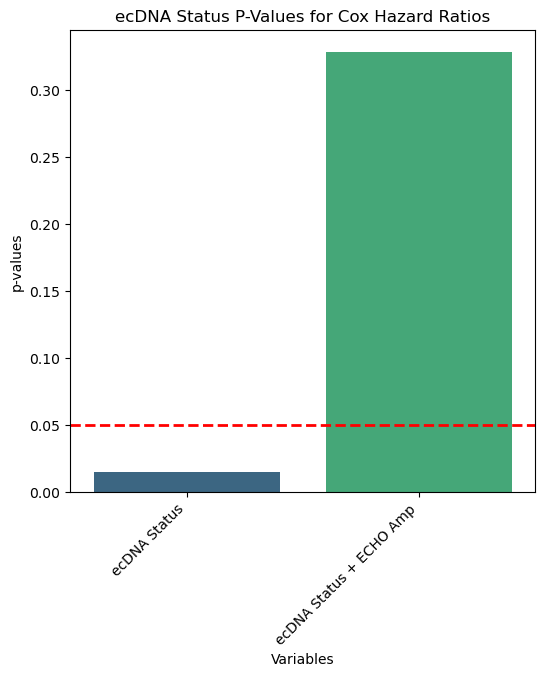

In [33]:
import seaborn as sns

specific_cox_df = specific_cox_df.sort_values(by='p_value')
plt.figure(figsize=(6, 6))
bars = sns.barplot(x='atype', y='p_value', data=specific_cox_df, palette='viridis')
plt.xlabel('Variables')
plt.ylabel('p-values')
plt.title('Sorted DataFrame Bar Plot')
bars.set_xticklabels(bars.get_xticklabels(), rotation=45, ha='right')
plt.axhline(y=0.05, color='r', linestyle='--', linewidth=2)
plt.title("ecDNA Status P-Values for Cox Hazard Ratios")
plt.show()

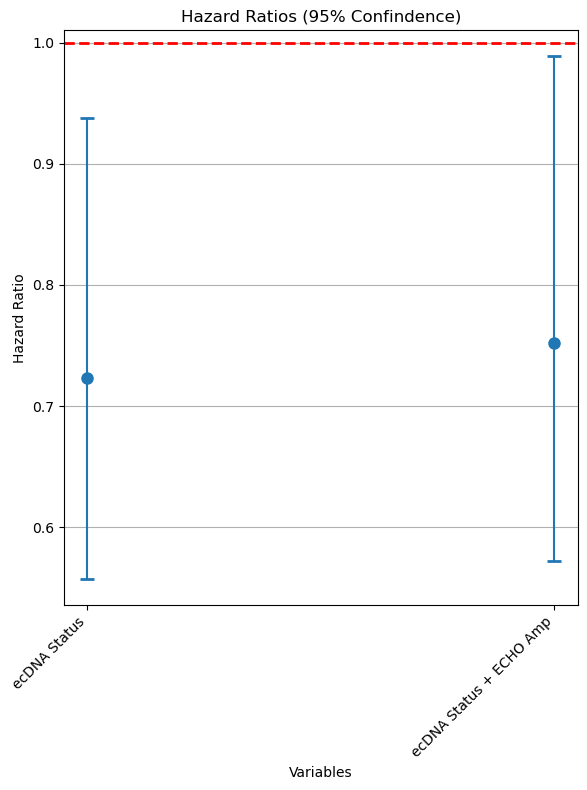

In [34]:
non_zero = specific_cox_df[specific_cox_df['lower'] != 0]

# Number of rows in the DataFrame
num_rows = non_zero.shape[0]

# Plotting points with error bars for each row
plt.figure(figsize=(6, 8))

# Plot points
positions = np.arange(num_rows)
plt.errorbar(positions, non_zero['hazardRatio'], yerr=[non_zero['hazardRatio'] - non_zero['lower'], non_zero['upper'] - non_zero['hazardRatio']],
             fmt='o', markersize=8, capsize=5, capthick=2)

# Set x-axis ticks and labels
plt.xlabel('Variables')
plt.xticks(positions, non_zero['atype'],rotation=45, ha='right')


# Add labels and title
plt.ylabel('Hazard Ratio')
plt.title('Hazard Ratios (95% Confindence)')
plt.axhline(y=1, color='r', linestyle='--', linewidth=2)

plt.grid(True, axis='y')  # Add grid lines for better visualization
plt.tight_layout()
plt.show()